<a href="https://colab.research.google.com/github/AliiAssi/Langgraph-Practice/blob/main/Chain_Module_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_mistralai langchain_core langgraph

In [ ]:
import os
os.environ["MISTRAL_API_KEY"] = "*_*" # add your api-key

In [ ]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(
    model="mistral-large-latest",
    temperature=0,
)

In [ ]:
ai_msg = llm.invoke("leo messi in 3 words?")
ai_msg

AIMessage(content='Describing Leo Messi in just three words is challenging given his extensive career and impact, but here are three that capture key aspects:\n\n1. **Skillful**\n2. **Consistent**\n3. **Iconic**\n\nThese words highlight his incredible talent, his sustained high level of performance over many years, and his status as one of the greatest footballers of all time.', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 12, 'total_tokens': 97, 'completion_tokens': 85}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-3a0453a7-1ec4-4ce5-9627-8d0509ccf7f5-0', usage_metadata={'input_tokens': 12, 'output_tokens': 85, 'total_tokens': 97})

### HERE WE GO

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [ ]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [ ]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '1SrrtltAv',
  'type': 'tool_call'}]

In [ ]:
import time
import random

def call_with_retry(func, max_retries=5):
    for attempt in range(max_retries):
        try:
            return func()
        except httpx.HTTPStatusError as e:
            if e.response.status_code == 429:
                # Exponential backoff with jitter
                sleep_time = (2 ** attempt) + random.random()
                print(f"Rate limited. Retrying in {sleep_time:.2f} seconds...")
                time.sleep(sleep_time)
                continue
            else:
                raise
    raise Exception("Max retries exceeded")

# Usage:
result = call_with_retry(lambda: llm_with_tools.invoke([HumanMessage(content="HELLO", name="ali")]))

In [ ]:
print(result)

content='Hello! How can I assist you today?' additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 92, 'total_tokens': 102, 'completion_tokens': 10}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'} id='run-c37d342c-f9bf-4878-bbd4-0b98b9505940-0' usage_metadata={'input_tokens': 92, 'output_tokens': 10, 'total_tokens': 102}


In [ ]:
llm_with_tools.invoke([HumanMessage(content=f"What is my name?", name="ali")])

AIMessage(content="I don't have access to personal information about you, including your name. If you'd like to share your name or have any other questions, feel free to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 94, 'total_tokens': 133, 'completion_tokens': 39}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run-39927a44-5a51-4f97-a5f1-b7de7090ef5f-0', usage_metadata={'input_tokens': 94, 'output_tokens': 39, 'total_tokens': 133})

In [ ]:
def get_user_name():
    return "ali"

In [ ]:
llm_with_tools = llm.bind_tools([get_user_name, multiply])

In [ ]:
res = llm_with_tools.invoke([HumanMessage(content="tell me my name", name="ali")])

In [ ]:
res.tool_calls

[{'name': 'get_user_name', 'args': {}, 'id': 'sXUgxbN6c', 'type': 'tool_call'}]

### Dependencies

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

### Rest

In [ ]:
class MessagesState(TypedDict):
    messages: list[AnyMessage]

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='9aaeb85e-049c-4240-8180-dc029f59d30c'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='de236d99-78ef-4faa-b04c-e2f3f7ec67f3'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='68c81579-8b13-4e3c-aa52-af9c44a12908')]

### Graph Building

In [ ]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [ ]:
# Build graph
builder = StateGraph(
  MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

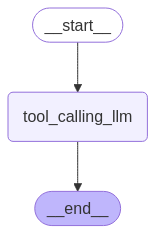

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    print(m)

content='Hello!' additional_kwargs={} response_metadata={} id='b9b4b1c9-51f2-4f9d-919d-77e7383fd649'
content='Hi! How can I assist you today?' additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 129, 'total_tokens': 139, 'completion_tokens': 10}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'} id='run-748fece5-f4a0-49c1-ad34-10f4dfd37ca6-0' usage_metadata={'input_tokens': 129, 'output_tokens': 10, 'total_tokens': 139}


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    print(m)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='d7f7470d-5b85-43be-8d30-d04aac13afca'
content='' additional_kwargs={'tool_calls': [{'id': 'EkFXHxoRj', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}, 'index': 0}]} response_metadata={'token_usage': {'prompt_tokens': 135, 'total_tokens': 161, 'completion_tokens': 26}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'} id='run-43f7a1fd-2919-4553-9821-f9d410105e55-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'EkFXHxoRj', 'type': 'tool_call'}] usage_metadata={'input_tokens': 135, 'output_tokens': 26, 'total_tokens': 161}


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="what is my name")})
for m in messages['messages']:
    print(m)

content='what is my name' additional_kwargs={} response_metadata={} id='580d6b07-8bbd-49c6-acc7-73d47deb7fea'
content='' additional_kwargs={'tool_calls': [{'id': 'RRBIE8B3q', 'function': {'name': 'get_user_name', 'arguments': '{}'}, 'index': 0}]} response_metadata={'token_usage': {'prompt_tokens': 131, 'total_tokens': 150, 'completion_tokens': 19}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'} id='run-d908c2dc-2eb4-444a-960d-262835a656a9-0' tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'RRBIE8B3q', 'type': 'tool_call'}] usage_metadata={'input_tokens': 131, 'output_tokens': 19, 'total_tokens': 150}


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content="what is the name of the FOOTBALL GOAT")})
for m in messages['messages']:
    print(m)

content='what is the name of the FOOTBALL GOAT' additional_kwargs={} response_metadata={} id='e70d1321-ddff-44dd-94c7-e8c45b53f2ee'
content='The name often associated with the title of the "GOAT" (Greatest Of All Time) in football (soccer) can vary depending on personal opinions and criteria. However, two names frequently mentioned in this context are:\n\n1. **Lionel Messi** - An Argentine forward known for his incredible dribbling skills, goal-scoring ability, and playmaking.\n2. **Cristiano Ronaldo** - A Portuguese forward renowned for his athleticism, goal-scoring prowess, and consistency.\n\nBoth players have had extraordinary careers with numerous records and accolades. The debate between Messi and Ronaldo is a common topic among football fans and analysts.' additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 139, 'total_tokens': 290, 'completion_tokens': 151}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'} id='